The python-awips package provides access to the entire AWIPS Maps Database for use in Python GIS applications.  Map objects are returned as **[Shapely](http://toblerity.org/shapely/manual.html)** geometries (*Polygon*, *Point*, *MultiLineString*, etc.) and can be easily plotted by Matplotlib, Cartopy, MetPy, and other packages. 

Each map database table has a geometry field called `the_geom`, which can be used to spatially select map resources for any column of type geometry,

### Notes


* This notebook requires: **python-awips, numpy, matplotplib, cartopy, shapely**
* Use datatype **maps** and **addIdentifier('table', &lt;postgres maps schema&gt;)** to define the map table:
        DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
        request = DataAccessLayer.newDataRequest('maps')
        request.addIdentifier('table', 'mapdata.county')
* Use **request.setLocationNames()** and **request.addIdentifier()** to spatially filter a map resource. In the example below, WFO ID **BOU** (Boulder, Colorado) is used to query counties within the BOU county watch area (CWA) 
    
        request.addIdentifier('geomField', 'the_geom')
        request.addIdentifier('inLocation', 'true')
        request.addIdentifier('locationField', 'cwa')
        request.setLocationNames('BOU')
        request.addIdentifier('cwa', 'BOU')
        
See the [Maps Database Reference Page](http://unidata.github.io/awips2/python/maps-database/#mapdatacwa) for available database tables, column names, and types. 
  
 > Note the geometry definition of `the_geom` for each data type, which can be **Point**, **MultiPolygon**, or **MultiLineString**.


## Setup

In [1]:
from __future__ import print_function
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

# Standard map plot
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# Server, Data Request Type, and Database Table
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest('maps')
request.addIdentifier('table', 'mapdata.county')

## Request County Boundaries for a WFO

* Use **request.setParameters()** to define fields to be returned by the request.

Using 25 county MultiPolygons


/Users/mjames/miniconda2/envs/python-awips/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/mjames/miniconda2/envs/python-awips/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/mjames/miniconda2/envs/python-awips/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


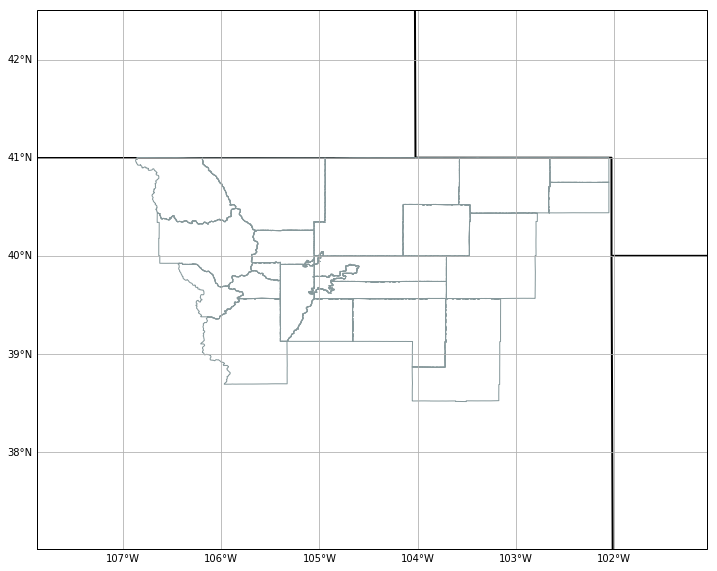

In [2]:
# Define a WFO ID for location
# tie this ID to the mapdata.county column "cwa" for filtering
request.setLocationNames('BOU')
request.addIdentifier('cwa', 'BOU')

# enable location filtering (inLocation)
# locationField is tied to the above cwa definition (BOU)
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'cwa')

# This is essentially the same as "'"select count(*) from mapdata.cwa where cwa='BOU';" (=1)

# Get response and create dict of county geometries
response = DataAccessLayer.getGeometryData(request, [])
counties = np.array([])
for ob in response:
    counties = np.append(counties,ob.getGeometry())
print("Using " + str(len(counties)) + " county MultiPolygons")


%matplotlib inline
# All WFO counties merged to a single Polygon
merged_counties = cascaded_union(counties)
envelope = merged_counties.buffer(2)
boundaries=[merged_counties]

# Get bounds of this merged Polygon to use as buffered map extent
bounds = merged_counties.bounds
bbox=[bounds[0]-1,bounds[2]+1,bounds[1]-1.5,bounds[3]+1.5]


fig, ax = make_map(bbox=bbox)
# Plot political/state boundaries handled by Cartopy
political_boundaries = NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')
ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)

# Plot CWA counties
for i, geom in enumerate(counties):
    cbounds = Polygon(geom)
    intersection = cbounds.intersection
    geoms = (intersection(geom)
         for geom in counties
         if cbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",edgecolor='#86989B')
    ax.add_feature(shape_feature)

## Create a merged CWA with cascaded_union

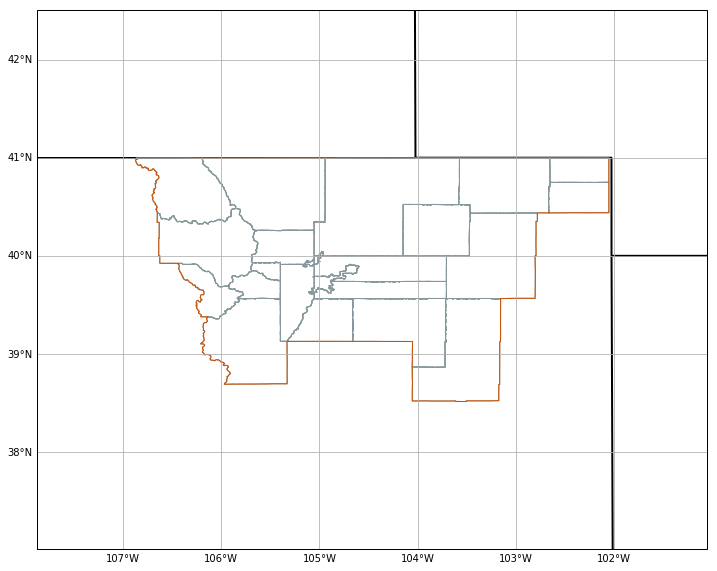

In [3]:
# Plot CWA envelope
for i, geom in enumerate(boundaries):
    gbounds = Polygon(geom)
    intersection = gbounds.intersection
    geoms = (intersection(geom)
         for geom in boundaries
         if gbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",linewidth=3.,edgecolor='#cc5000')
    ax.add_feature(shape_feature)

fig

## WFO boundary spatial filter for interstates, cities, topo

Using the previously-defined **envelope=merged_counties.buffer(2)** in **newDataRequest()** to request geometries which fall inside the buffered boundary. 

Using 223 interstate MultiLineStrings


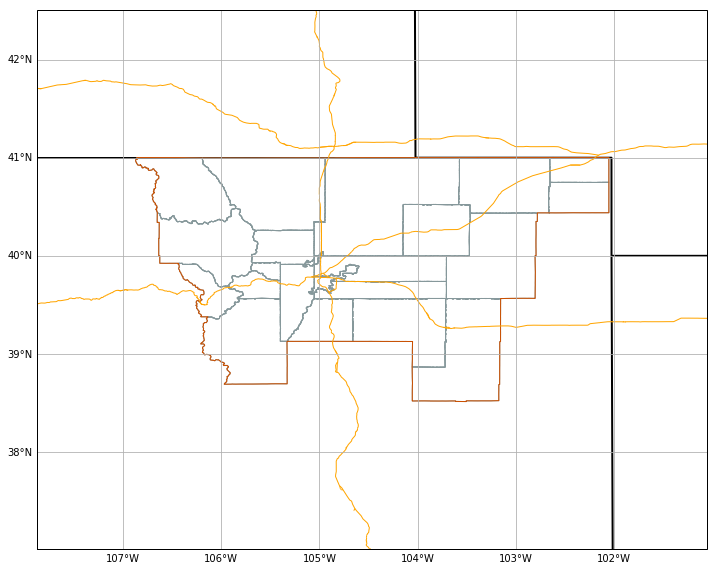

In [4]:
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.interstate')
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('locationField', 'hwy_type')
request.addIdentifier('hwy_type', 'I') # I (interstate), U (US highway), or S (state highway)
request.setParameters('name')
interstates = DataAccessLayer.getGeometryData(request, [])
print("Using " + str(len(interstates)) + " interstate MultiLineStrings")

# Plot interstates
for ob in interstates:
    shape_feature = ShapelyFeature(ob.getGeometry(),ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",edgecolor='orange')
    ax.add_feature(shape_feature)
fig

> Road type from `select distinct(hwy_type) from mapdata.interstate;`
>
>         I - Interstates
>         U - US Highways
>         S - State Highways
         
         
### Nearby cities

In [5]:
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.city')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('name','population','prog_disc')
cities = DataAccessLayer.getGeometryData(request, [])
print("Found " + str(len(cities)) + " city Points")

Found 1201 city Points


### Filter cities by population and progressive disclosure level

**Warning**: the `prog_disc` field is not entirely understood and values appear to change significantly depending on WFO site.  

Using 57 city Points


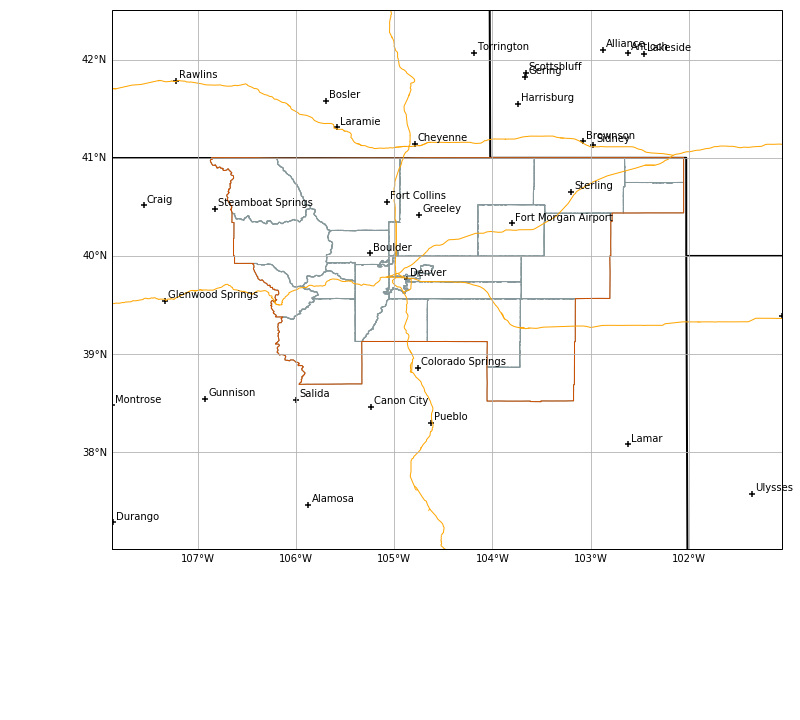

In [6]:
citylist = []
cityname = []
# For BOU, progressive disclosure values above 50 and pop above 5000 looks good
for ob in cities:
    if ((ob.getNumber("prog_disc")>50) and int(ob.getString("population")) > 5000):
        citylist.append(ob.getGeometry())
        cityname.append(ob.getString("name"))
print("Using " + str(len(cityname)) + " city Points")

# Plot city markers
ax.scatter([point.x for point in citylist],
       [point.y for point in citylist],
       transform=ccrs.Geodetic(),marker="+",facecolor='black')
# Plot city names
for i, txt in enumerate(cityname):
    ax.annotate(txt, (citylist[i].x,citylist[i].y),
                xytext=(3,3), textcoords="offset points")

fig

## Lakes

Using 208 lake MultiPolygons


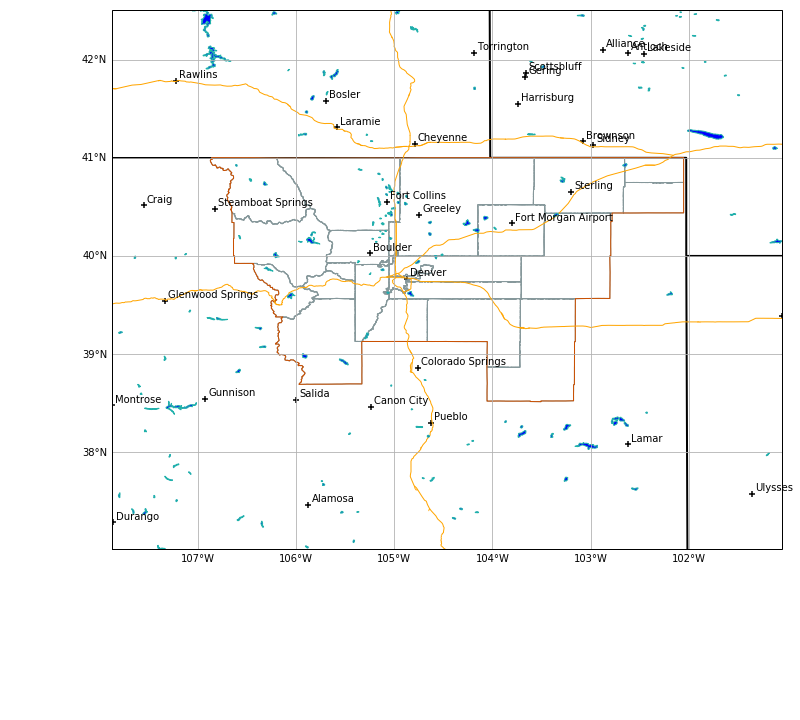

In [7]:
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.lake')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('name')

# Get lake geometries
response = DataAccessLayer.getGeometryData(request, [])
lakes = np.array([])
for ob in response:
    lakes = np.append(lakes,ob.getGeometry())
print("Using " + str(len(lakes)) + " lake MultiPolygons")

# Plot lakes
for i, geom in enumerate(lakes):
    cbounds = Polygon(geom)
    intersection = cbounds.intersection
    geoms = (intersection(geom)
         for geom in lakes
         if cbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='blue', linestyle="-",edgecolor='#20B2AA')
    ax.add_feature(shape_feature)
fig


## Major Rivers

Using 758 river MultiLineStrings


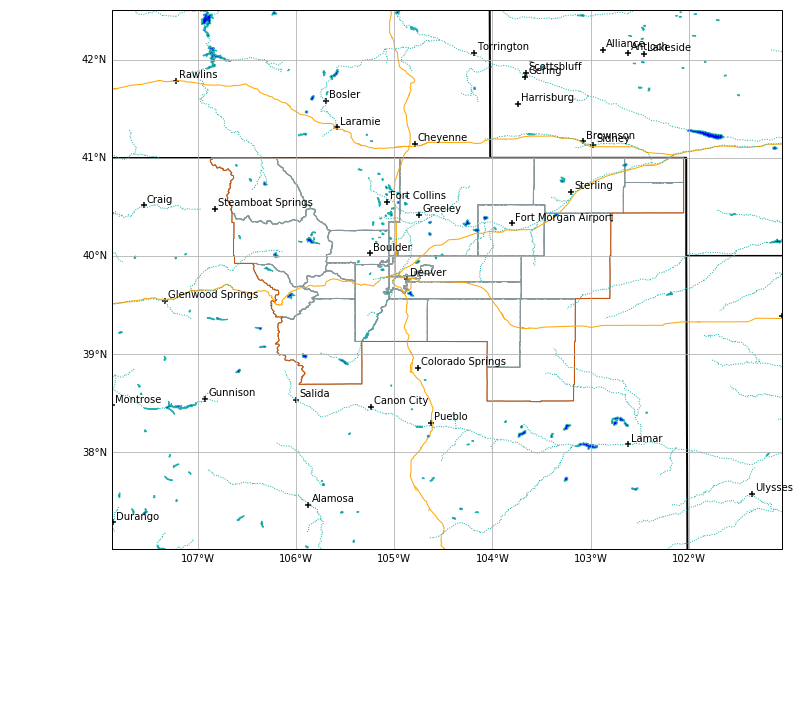

In [8]:
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.majorrivers')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('pname')
rivers = DataAccessLayer.getGeometryData(request, [])
print("Using " + str(len(rivers)) + " river MultiLineStrings")

# Plot rivers
for ob in rivers:
    shape_feature = ShapelyFeature(ob.getGeometry(),ccrs.PlateCarree(), 
                        facecolor='none', linestyle=":",edgecolor='#20B2AA')
    ax.add_feature(shape_feature)
fig

### Topography

Spatial envelopes are required for topo requests, which can become slow to download and render for large (CONUS) maps.

In [9]:
import numpy.ma as ma
request = DataAccessLayer.newDataRequest()
request.setDatatype("topo")
request.addIdentifier("group", "/")
request.addIdentifier("dataset", "full")
request.setEnvelope(envelope)
gridData = DataAccessLayer.getGridData(request)
print(gridData)
print("Number of grid records: " + str(len(gridData)))
print("Sample grid data shape:\n" + str(gridData[0].getRawData().shape) + "\n")
print("Sample grid data:\n" + str(gridData[0].getRawData()) + "\n")

Number of grid records: 1
Sample grid data shape:
(778, 1058)

Sample grid data:
[[ 1694.  1693.  1688. ...,   757.   761.   762.]
 [ 1701.  1701.  1701. ...,   758.   760.   762.]
 [ 1703.  1703.  1703. ...,   760.   761.   762.]
 ..., 
 [ 1767.  1741.  1706. ...,   769.   762.   768.]
 [ 1767.  1746.  1716. ...,   775.   765.   761.]
 [ 1781.  1753.  1730. ...,   766.   762.   759.]]



623.0
4328.0


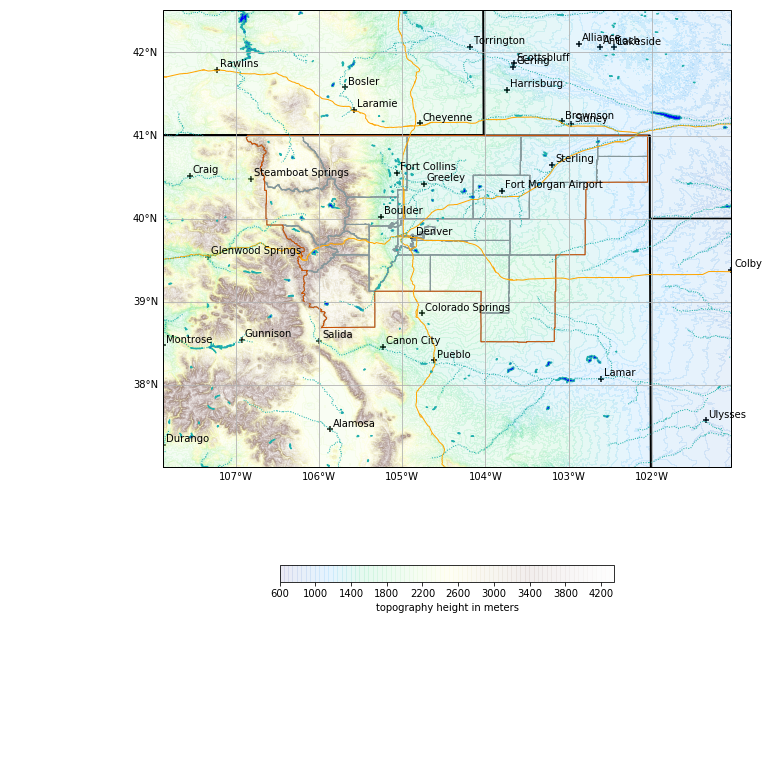

In [10]:
grid=gridData[0]
topo=ma.masked_invalid(grid.getRawData()) 
lons, lats = grid.getLatLonCoords()
print(topo.min())
print(topo.max())

# Plot topography
cs = ax.contourf(lons, lats, topo, 80, cmap=plt.get_cmap('terrain'),alpha=0.1)
cbar = fig.colorbar(cs, extend='both', shrink=0.5, orientation='horizontal')
cbar.set_label("topography height in meters")

fig